In [16]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import sys
sys.path.append('..')
from arrests_columns import ArrestsColumns
from detentions_columns import DetentionsColumns

In [17]:
proc_dir = pathlib.Path('../proc_data/')
assert proc_dir.exists() and len(list(proc_dir.glob('*.parquet'))) > 0

In [18]:
arrests_d = pd.read_parquet(proc_dir / 'arrests.parquet')
detentions_d = pd.read_parquet(proc_dir / 'detentions.parquet')

In [20]:
arrests_d.columns

Index(['Apprehension Date', 'Apprehension State', 'Apprehension AOR',
       'Final Program', 'Apprehension Method', 'Apprehension Criminality',
       'Case Status', 'Case Category', 'Departed Date', 'Departure Country',
       'Final Order Yes No', 'Final Order Date', 'Birth Year',
       'Citizenship Country', 'Gender', 'Apprehension Site Landmark',
       'Unique Identifier'],
      dtype='object')

In [ ]:
# restrict datasets to only be for september 2023 to July 2025

In [15]:
arrests_d.columns

Index(['Apprehension Date', 'Apprehension State', 'Apprehension AOR',
       'Final Program', 'Apprehension Method', 'Apprehension Criminality',
       'Case Status', 'Case Category', 'Departed Date', 'Departure Country',
       'Final Order Yes No', 'Final Order Date', 'Birth Year',
       'Citizenship Country', 'Gender', 'Apprehension Site Landmark',
       'Unique Identifier'],
      dtype='object')

In [9]:
arrests_subset = arrests_d[[ArrestsColumns.UNIQUE_IDENTIFIER, ArrestsColumns.APPREHENSION_DATE, ArrestsColumns.APPREHENSION_STATE, ArrestsColumns.APPREHENSION_AOR, 
                            ArrestsColumns.APPREHENSION_CRIMINALITY, ArrestsColumns.BIRTH_YEAR, ArrestsColumns.CITIZENSHIP_COUNTRY]]
detentions_subset = detentions_d[[DetentionsColumns.UNIQUE_IDENTIFIER, DetentionsColumns.STAY_BOOK_IN_DATE_TIME, DetentionsColumns.STAY_BOOK_OUT_DATE_TIME,
                                  DetentionsColumns.DETENTION_FACILITY,  DetentionsColumns.DEPARTED_DATE, DetentionsColumns.DEPARTURE_COUNTRY,
                                  DetentionsColumns.DETENTION_RELEASE_REASON, DetentionsColumns.MSC_CHARGE, DetentionsColumns.FELON, ]]
d = pd.merge(arrests_subset, detentions_subset, on = DetentionsColumns.UNIQUE_IDENTIFIER, how = 'inner').drop_duplicates().reset_index(drop=True)
d.shape

(750366, 15)

In [10]:
msc_detentions_d = d[[ArrestsColumns.UNIQUE_IDENTIFIER, DetentionsColumns.MSC_CHARGE]].drop_duplicates().copy()
msc_detentions_d[DetentionsColumns.MSC_CHARGE].isna().value_counts()

MSC Charge
True     122381
False    120769
Name: count, dtype: int64

In [11]:
d.head()

,Unique Identifier,Apprehension Date,Apprehension State,Apprehension AOR,Apprehension Criminality,Birth Year,Citizenship Country,Stay Book In Date Time,Stay Book Out Date Time,Detention Facility,Departed Date,Departure Country,Detention Release Reason,MSC Charge,Felon
0,000066a0cf0da888503506a0bd39e0772fada2ce,2025-07-26 18:50:27,TEXAS,Houston Area of Responsibility,3 Other Immigration Violator,2002,HONDURAS,2025-07-26 19:28:00,NaT,MONTGOMERY PROCESSING CTR,NaT,None,None,None,Not an Aggravated Felon
1,0000718e93d4f75cdec49ccdd21bf7a09f48a8b7,2025-07-02 17:57:46,NEVADA,Salt Lake City Area of Responsibility,2 Pending Criminal Charges,1984,MEXICO,2025-07-02 06:50:00,NaT,HENDERSON DETENTION,NaT,None,Transferred,None,Not an Aggravated Felon
2,0000718e93d4f75cdec49ccdd21bf7a09f48a8b7,2025-07-02 17:57:46,NEVADA,Salt Lake City Area of Responsibility,2 Pending Criminal Charges,1984,MEXICO,2025-07-02 06:50:00,NaT,NEVADA SOUTHERN DETENTION CENTER,NaT,None,None,None,Not an Aggravated Felon
3,0000f265b1ff8abbfbec54888dd2cddb62e21625,2024-07-05 10:22:00,NEW YORK,New York City Area of Responsibility,1 Convicted Criminal,1968,GUYANA,2024-07-05 11:58:00,2024-09-04 19:18:00,NYC HOLD ROOM,2024-09-05,GUYANA,Transferred,Sex Assault - Carnal Abuse,Not an Aggravated Felon
4,0000f265b1ff8abbfbec54888dd2cddb62e21625,2024-07-05 10:22:00,NEW YORK,New York City Area of Responsibility,1 Convicted Criminal,1968,GUYANA,2024-07-05 11:58:00,2024-09-04 19:18:00,MOSHANNON VALLEY PROCESSING CENTER,2024-09-05,GUYANA,Removed,Sex Assault - Carnal Abuse,Not an Aggravated Felon


In [13]:
detentions_d[DetentionsColumns.STAY_BOOK_IN_DATE_TIME].apply(lambda x: x.year).value_counts()

Stay Book In Date Time
2024    583204
2025    491206
2023    245180
2022      2503
2021       233
2020        91
2019        47
2018        21
2017         6
2014         3
2004         3
2016         1
2015         1
Name: count, dtype: int64

In [7]:
d[ArrestsColumns.UNIQUE_IDENTIFIER].nunique()

241801

<Axes: xlabel='Apprehension Date', ylabel='Count'>

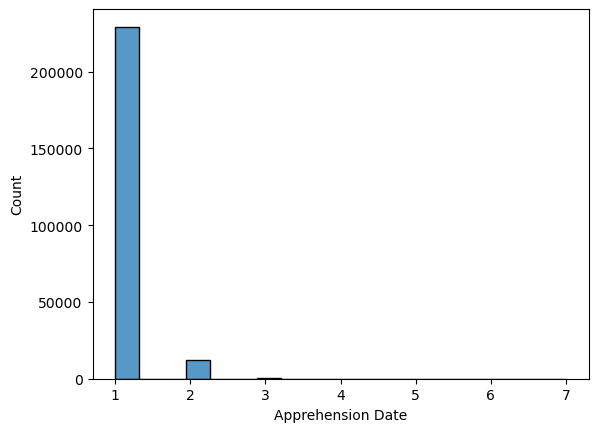

In [8]:
# how many arrests are associated to each identifier?
sns.histplot(d.groupby(ArrestsColumns.UNIQUE_IDENTIFIER).nunique()[ArrestsColumns.APPREHENSION_DATE])

<Axes: xlabel='Stay Book In Date Time', ylabel='Count'>

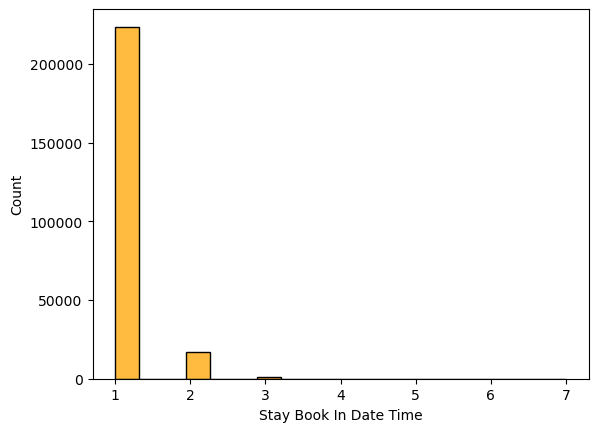

In [9]:
# how many detentions are associated to each identifier?
sns.histplot(d.groupby(ArrestsColumns.UNIQUE_IDENTIFIER).nunique()[DetentionsColumns.STAY_BOOK_IN_DATE_TIME], color='orange')

In [10]:
d['EST_DETENTION_LENGTH_DAYS'] = (d[DetentionsColumns.STAY_BOOK_OUT_DATE_TIME] - d[DetentionsColumns.STAY_BOOK_IN_DATE_TIME]).apply(lambda x: x.days)
d['EST_AGE'] = datetime.now().year - d[ArrestsColumns.BIRTH_YEAR]
d['DEPART_COUNTRY_EQUALS_CITIZENSHIP'] = d[ArrestsColumns.CITIZENSHIP_COUNTRY] == d[DetentionsColumns.DEPARTURE_COUNTRY]

<Axes: xlabel='EST_AGE', ylabel='EST_DETENTION_LENGTH_DAYS'>

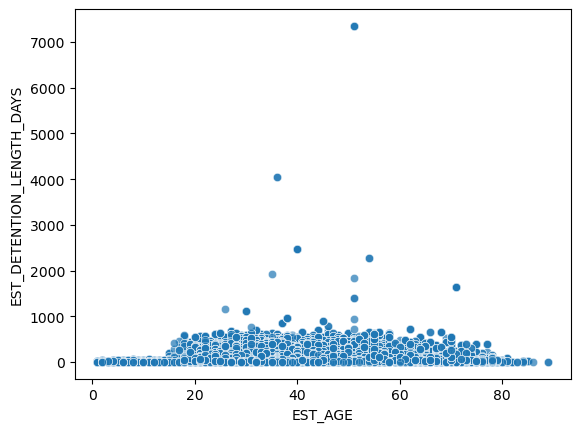

In [11]:
sns.scatterplot(data = d, x = 'EST_AGE', y = 'EST_DETENTION_LENGTH_DAYS', alpha=0.7)

<Axes: xlabel='EST_AGE', ylabel='EST_DETENTION_LENGTH_DAYS'>

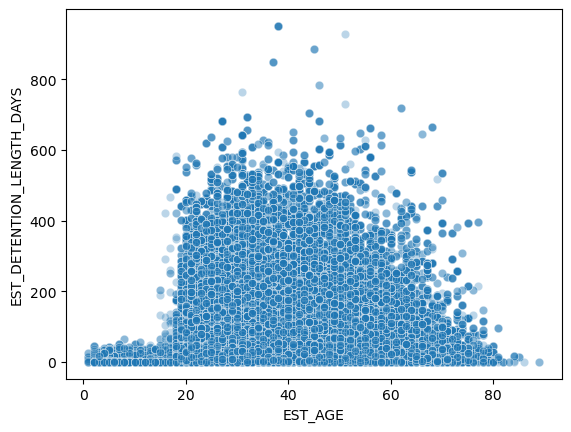

In [12]:
# remove outlier detention lengths to more easily see if there is a correlation
sns.scatterplot(data = d[d['EST_DETENTION_LENGTH_DAYS'] < 1000], x = 'EST_AGE', y = 'EST_DETENTION_LENGTH_DAYS', alpha=0.3)

In [13]:
d[d['EST_DETENTION_LENGTH_DAYS'] > 5000]

,Unique Identifier,Apprehension Date,Apprehension State,Apprehension AOR,Apprehension Criminality,Birth Year,Citizenship Country,Stay Book In Date Time,Stay Book Out Date Time,Detention Facility,Departed Date,Departure Country,Detention Release Reason,MSC Charge,Felon,EST_DETENTION_LENGTH_DAYS,EST_AGE,DEPART_COUNTRY_EQUALS_CITIZENSHIP
275810,5e39f10da83341f6e62d7ec611c011a6052d19b2,2024-12-05 13:05:00,None,El Paso Area of Responsibility,3 Other Immigration Violator,1974,BRAZIL,2004-12-05 22:30:00,2025-01-23 22:30:00,HCA HOUSTON HC CONROE,2025-01-24,BRAZIL,Transferred,None,None,7354.0,51,True
275811,5e39f10da83341f6e62d7ec611c011a6052d19b2,2024-12-05 13:05:00,None,El Paso Area of Responsibility,3 Other Immigration Violator,1974,BRAZIL,2004-12-05 22:30:00,2025-01-23 22:30:00,JOE CORLEY PROCESSING CTR,2025-01-24,BRAZIL,Transferred,None,None,7354.0,51,True
275812,5e39f10da83341f6e62d7ec611c011a6052d19b2,2024-12-05 13:05:00,None,El Paso Area of Responsibility,3 Other Immigration Violator,1974,BRAZIL,2004-12-05 22:30:00,2025-01-23 22:30:00,JOE CORLEY PROCESSING CTR,2025-01-24,BRAZIL,Removed,None,None,7354.0,51,True


In [14]:
d[DetentionsColumns.DETENTION_FACILITY].nunique()

730

In [15]:
top_20_detention_facilities = d[DetentionsColumns.DETENTION_FACILITY].value_counts().index[:20].to_numpy()
top_20_detention_facilities

array(['ALEXANDRIA STAGING FACILITY', 'MONTGOMERY PROCESSING CTR',
       'FLORENCE STAGING FACILITY', 'PINE PRAIRIE ICE PROCESSING CENTER',
       'MONTGOMERY HOLD RM', 'PRAIRIELAND DETENTION CENTER',
       'DALLAS F.O. HOLD', 'KROME NORTH SPC',
       'CENTRAL LOUISIANA ICE PROC CTR', 'PORT ISABEL SPC',
       'STEWART DETENTION CENTER', 'BLUEBONNET DET FCLTY',
       'MOSHANNON VALLEY PROCESSING CENTER', 'LOS CUST CASE',
       'SOUTH TEXAS ICE PROCESSING CENTER',
       'DENVER CONTRACT DETENTION FACILITY', 'WINN CORRECTIONAL CENTER',
       'EL PASO SOFT SIDED FACILITY', 'NYC HOLD ROOM',
       'PHOENIX DIST OFFICE'], dtype=object)

<Axes: xlabel='EST_DETENTION_LENGTH_DAYS', ylabel='DetentionsColumns.DETENTION_FACILITY'>

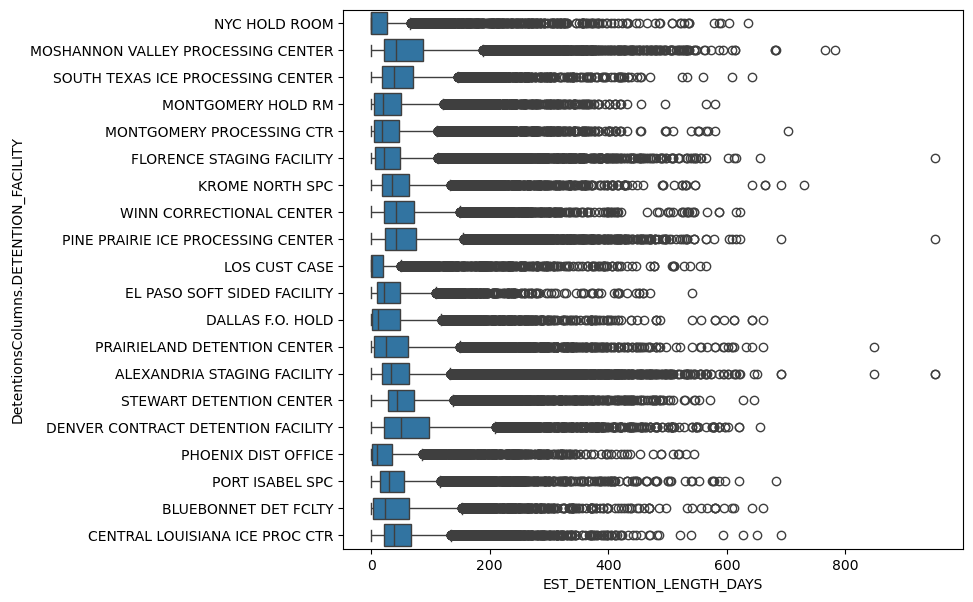

In [16]:
# are detentions longer depending on the detention state?
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.boxplot(data = d[(d['EST_DETENTION_LENGTH_DAYS'] < 1000) & (d[DetentionsColumns.DETENTION_FACILITY].isin(top_20_detention_facilities))],
                x = 'EST_DETENTION_LENGTH_DAYS', y = DetentionsColumns.DETENTION_FACILITY)  # , alpha=0.5

In [17]:
d[ArrestsColumns.APPREHENSION_CRIMINALITY].nunique()

3

<Axes: xlabel='EST_DETENTION_LENGTH_DAYS', ylabel='ArrestsColumns.APPREHENSION_CRIMINALITY'>

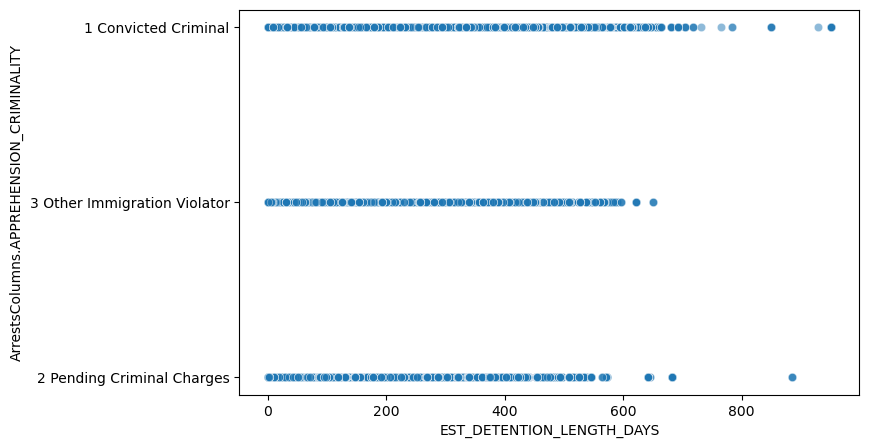

In [18]:
# do detention lengths vary by arrests criminality?
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.scatterplot(data = d[(d['EST_DETENTION_LENGTH_DAYS'] < 1000)], x = 'EST_DETENTION_LENGTH_DAYS', 
                y = ArrestsColumns.APPREHENSION_CRIMINALITY, alpha=0.5)

In [19]:
# not sure how to reliably find which state the different facilities are located

<Axes: xlabel='index', ylabel='EST_DETENTION_LENGTH_DAYS'>

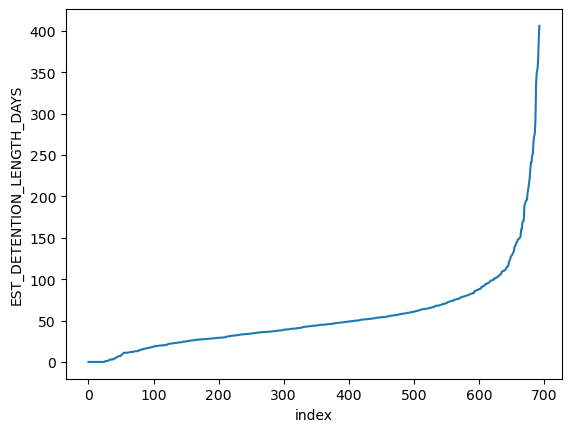

In [20]:
facility_means_d = d[[DetentionsColumns.DETENTION_FACILITY, 'EST_DETENTION_LENGTH_DAYS', 'EST_AGE']].groupby(DetentionsColumns.DETENTION_FACILITY).mean()
facility_means_d = facility_means_d.sort_values(by = 'EST_DETENTION_LENGTH_DAYS')
facility_means_d['index'] = np.arange(len(facility_means_d))
sns.lineplot(data = facility_means_d, x = 'index', y = 'EST_DETENTION_LENGTH_DAYS')

In [21]:
d[DetentionsColumns.FELON].value_counts()

Felon
Not an Aggravated Felon                        496808
Other                                           10565
Drugs                                            4920
Both (drug and other agg felon convictions)      1452
Name: count, dtype: int64

In [22]:
d['IS_FELON'] = (d[DetentionsColumns.FELON]
                 .apply(lambda x: x in ['Other', 'Drugs', 'Both (drug and other agg felon convictions)'])
                 .apply(lambda x: 1 if x else 0))
d['IS_FELON'].value_counts()

IS_FELON
0    733429
1     16937
Name: count, dtype: int64

In [23]:
# detentions_d[['IS_FELON', DetentionsColumns.FELON]].sample(20)

In [24]:
# while there is missing data, we're assuming this value is as accurate as possible
d['IS_DEPORTED'] = (~d[DetentionsColumns.DEPARTURE_COUNTRY].isna() & (d[DetentionsColumns.DETENTION_RELEASE_REASON] != 'Transferred')).apply(lambda x: 1 if x else 0)
d['IS_DEPORTED'].value_counts()

IS_DEPORTED
0    567398
1    182968
Name: count, dtype: int64

In [25]:
d[['IS_DEPORTED', DetentionsColumns.DEPARTURE_COUNTRY, DetentionsColumns.DETENTION_RELEASE_REASON]].sample(20)

,IS_DEPORTED,Departure Country,Detention Release Reason
319056,0,None,Bonded Out - IJ
281757,0,MEXICO,Transferred
396169,0,None,Transferred
217462,0,None,Order of recognizance
431041,1,GUATEMALA,Removed
143687,0,None,Transferred
225783,1,MEXICO,Removed
582024,0,EL SALVADOR,Transferred
428414,0,GUATEMALA,Transferred
449008,0,None,Order of recognizance


In [26]:
felon_deport_cont_table_d = (d.groupby(by=['IS_FELON', 'IS_DEPORTED'])
                             .count().iloc[:,:1]
                             .rename(columns={d.columns[0]:'n'}))
felon_deport_cont_table_d

n
IS_FELON IS_DEPORTED        
0        0            555325
         1            178104
1        0             12073
         1              4864

In [27]:
178104 / (555325 + 178104)

0.2428374116649328

In [28]:
4864 / (12073 + 4864)

0.28718190942906063

Text(0.5, 23.52222222222222, 'IS_DEPORTED')

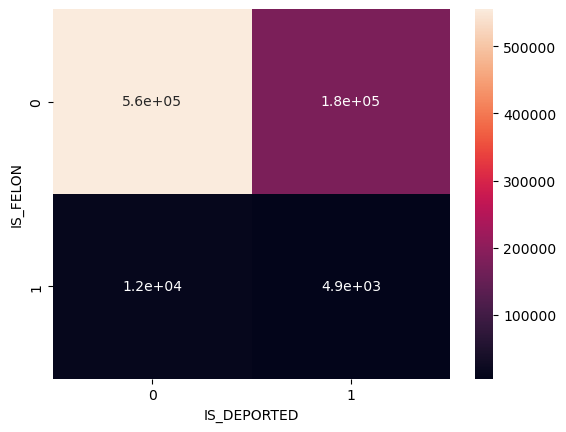

In [29]:
sns.heatmap(np.array([[felon_deport_cont_table_d.loc[(0, 0),:].item(), felon_deport_cont_table_d.loc[(0, 1),:].item()],
                      [felon_deport_cont_table_d.loc[(1, 0),:].item(), felon_deport_cont_table_d.loc[(1, 1),:].item()]]),
            annot=True
           )
plt.ylabel('IS_FELON')
plt.xlabel('IS_DEPORTED')

In [30]:
d[[ArrestsColumns.CITIZENSHIP_COUNTRY]]

,Citizenship Country
0,HONDURAS
1,MEXICO
2,MEXICO
3,GUYANA
4,GUYANA
...,...
750361,GUATEMALA
750362,ERITREA
750363,ERITREA
750364,MEXICO


In [31]:
{ArrestsColumns.CITIZENSHIP_COUNTRY.value: 'CITIZENSHIP_COUNTRY'}

{'Citizenship Country': 'CITIZENSHIP_COUNTRY'}

In [32]:
# any departure countries (or citizenship countries) have outlier proportions?

# first, setup a dataframe with all possible values to make imputing easier
country_flags_d = pd.DataFrame([{'CITIZENSHIP_COUNTRY': cc,
                                 'IS_FELON': flag_a, 'IS_DEPORTED': flag_b}
                                for cc in d[ArrestsColumns.CITIZENSHIP_COUNTRY].unique()
                                for flag_a in [0, 1]
                                for flag_b in [0, 1]])

country_flags_grp_d = (d.rename(columns={ArrestsColumns.CITIZENSHIP_COUNTRY.value: 'CITIZENSHIP_COUNTRY'})
                       [[ArrestsColumns.UNIQUE_IDENTIFIER, 'CITIZENSHIP_COUNTRY', 'IS_FELON', 'IS_DEPORTED']]
                       .groupby(by=['CITIZENSHIP_COUNTRY', 'IS_FELON', 'IS_DEPORTED'])
                       .nunique()[[ArrestsColumns.UNIQUE_IDENTIFIER]]
                       .rename(columns={ArrestsColumns.UNIQUE_IDENTIFIER: 'num_persons'})
                       .reset_index(drop=False))

country_flags_d = (country_flags_d.merge(country_flags_grp_d,
                                         on = ['CITIZENSHIP_COUNTRY', 'IS_FELON', 'IS_DEPORTED'],
                                         how = 'left').fillna(0))
country_flags_d['num_persons'] = country_flags_d['num_persons'].apply(int)

country_totals_d = (country_flags_d[['CITIZENSHIP_COUNTRY', 'num_persons']]
                    .groupby('CITIZENSHIP_COUNTRY').sum()
                    .rename(columns={'num_persons': 'total_persons'})
                    .reset_index(drop=False))

country_flags_d = country_flags_d.merge(country_totals_d, on = 'CITIZENSHIP_COUNTRY', how = 'left')
country_flags_d['num_persons_prop'] = country_flags_d['num_persons'] / country_flags_d['total_persons']
country_flags_d = country_flags_d.sort_values(by = 'CITIZENSHIP_COUNTRY')

country_flags_d.head()

,CITIZENSHIP_COUNTRY,IS_FELON,IS_DEPORTED,num_persons,total_persons,num_persons_prop
167,AFGHANISTAN,1,1,0,181,0.000000
166,AFGHANISTAN,1,0,4,181,0.022099
165,AFGHANISTAN,0,1,13,181,0.071823
164,AFGHANISTAN,0,0,164,181,0.906077
447,ALBANIA,1,1,2,66,0.030303


Text(0.5, 1.0, 'IS_FELON=1, IS_DEPORTED=1')

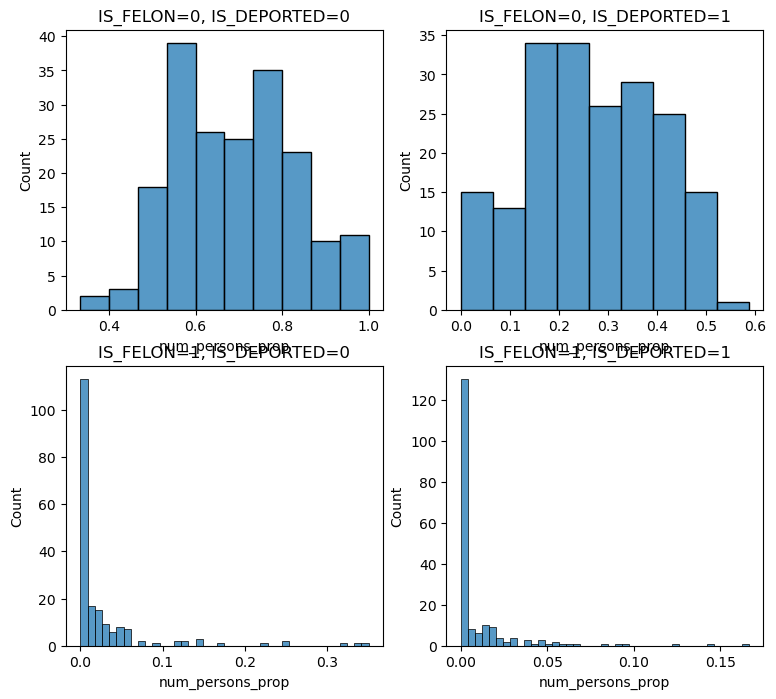

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(9,8))
sns.histplot(country_flags_d[(country_flags_d['IS_FELON'] == 0) & (country_flags_d['IS_DEPORTED'] == 0)], x = 'num_persons_prop', ax = ax[0, 0])
sns.histplot(country_flags_d[(country_flags_d['IS_FELON'] == 1) & (country_flags_d['IS_DEPORTED'] == 0)], x = 'num_persons_prop', ax = ax[1, 0])
sns.histplot(country_flags_d[(country_flags_d['IS_FELON'] == 0) & (country_flags_d['IS_DEPORTED'] == 1)], x = 'num_persons_prop', ax = ax[0, 1])
sns.histplot(country_flags_d[(country_flags_d['IS_FELON'] == 1) & (country_flags_d['IS_DEPORTED'] == 1)], x = 'num_persons_prop', ax = ax[1, 1])
ax[0, 0].set_title('IS_FELON=0, IS_DEPORTED=0')
ax[1, 0].set_title('IS_FELON=1, IS_DEPORTED=0')
ax[0, 1].set_title('IS_FELON=0, IS_DEPORTED=1')
ax[1, 1].set_title('IS_FELON=1, IS_DEPORTED=1')

In [34]:
# majority of persons of different citizenships are not felons
# among those that are not felons, different rates of is_deported for different countries

In [35]:
(country_flags_d[(country_flags_d['IS_DEPORTED'] == 1) & (country_flags_d['num_persons'] > 2)]
 .sort_values(by = 'num_persons_prop', ascending=False)
 .head(30))

,CITIZENSHIP_COUNTRY,IS_FELON,IS_DEPORTED,num_persons,total_persons,num_persons_prop
261,"MICRONESIA, FEDERATED STATES OF",0,1,141,240,0.587500
361,IRELAND,0,1,57,112,0.508929
589,JAPAN,0,1,6,12,0.500000
721,MAURITIUS,0,1,3,6,0.500000
377,SLOVAKIA,0,1,9,18,0.500000
417,PALAU,0,1,10,21,0.476190
565,TONGA,0,1,16,34,0.470588
549,BELGIUM,0,1,11,24,0.458333
545,HUNGARY,0,1,30,66,0.454545
285,NETHERLANDS,0,1,24,53,0.452830


https://en.wikipedia.org/wiki/Federated_States_of_Micronesia

Why is Yugoslavia citizenship in the data??? the nation hasn't officially existed since 1992??

In [36]:
(country_flags_d[(country_flags_d['IS_FELON'] == 1) & (country_flags_d['num_persons'] > 2)]
 .sort_values(by = 'num_persons_prop', ascending=False)
 .head(30))

,CITIZENSHIP_COUNTRY,IS_FELON,IS_DEPORTED,num_persons,total_persons,num_persons_prop
94,LAOS,1,0,105,300,0.350000
130,VIETNAM,1,0,270,855,0.315789
290,CAMBODIA,1,0,27,123,0.219512
502,USSR,1,0,3,21,0.142857
294,THAILAND,1,0,13,92,0.141304
306,BOSNIA-HERZEGOVINA,1,0,8,61,0.131148
182,LIBERIA,1,0,23,190,0.121053
158,IRAN,1,0,52,445,0.116854
95,LAOS,1,1,29,300,0.096667
291,CAMBODIA,1,1,10,123,0.081301


In [37]:
d.columns

Index(['Unique Identifier', 'Apprehension Date', 'Apprehension State',
       'Apprehension AOR', 'Apprehension Criminality', 'Birth Year',
       'Citizenship Country', 'Stay Book In Date Time',
       'Stay Book Out Date Time', 'Detention Facility', 'Departed Date',
       'Departure Country', 'Detention Release Reason', 'MSC Charge', 'Felon',
       'EST_DETENTION_LENGTH_DAYS', 'EST_AGE',
       'DEPART_COUNTRY_EQUALS_CITIZENSHIP', 'IS_FELON', 'IS_DEPORTED'],
      dtype='object')

In [38]:
d[DetentionsColumns.MSC_CHARGE].sort_values().unique().shape

(388,)

In [39]:
d[DetentionsColumns.MSC_CHARGE].apply(lambda x: x.split('-')[0].strip() if type(x) == str and ' - ' in x else x).value_counts()

MSC Charge
Driving Under Influence Liquor                             53365
Assault                                                    28970
Traffic Offense                                            20728
Illegal Re-Entry (INA SEC.101(a)(43)(O), 8USC1326 only)    20290
Illegal Entry (INA SEC.101(a)(43)(O), 8USC1325 only)       17976
                                                           ...  
Establish Gambling Place                                       2
Homicide-Willful Kill-Police Officer-Gun                       1
False Imprisonment-Minor-Parental                              1
Abscond While On Probation                                     1
Frequent House Ill Fame                                        1
Name: count, Length: 254, dtype: int64

In [43]:
arrests_d[ArrestsColumns.APPREHENSION_SITE_LANDMARK].value_counts()

Apprehension Site Landmark
DALLAS COUNTY GENERAL AREA                       11929
MTG GENERAL AREA, NON-SPECIFIC                   10261
NDD - 26 FEDERAL PLAZA NY, NY                     6241
LOS ANGELES COUNTY GENERAL AREA, NON-SPECIFIC     5383
HARRIS COUNTY JAIL, HOUSTON, TX                   4982
                                                 ...  
HAMILTON COUNTY JAIL, NE                             1
CAP-USMS - MIDDLE DISTRICT OF PENNSYLVANIA           1
KETCHIKAN CORRECTIONAL CENTER                        1
ST JOHN COUNTY PROBATION & PAROLE                    1
AUDRAIN COUNTY SHERIFF'S DEPARTMENT, MISSOURI        1
Name: count, Length: 5096, dtype: int64

In [44]:
detentions_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322499 entries, 0 to 1322498
Data columns (total 33 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   Stay Book In Date Time        1322499 non-null  datetime64[ns]
 1   Book In Date Time             1322499 non-null  datetime64[ns]
 2   Detention Facility            1322499 non-null  object        
 3   Detention Facility Code       1322499 non-null  object        
 4   Detention Book Out Date Time  1265862 non-null  datetime64[ns]
 5   Stay Book Out Date Time       1173530 non-null  datetime64[ns]
 6   Detention Release Reason      1265862 non-null  object        
 7   Stay Book Out Date            1173530 non-null  datetime64[ns]
 8   Stay Release Reason           1173533 non-null  object        
 9   Religion                      38790 non-null    object        
 10  Gender                        1322499 non-null  object        
 11

In [45]:
detentions_d.sample(5).to_dict(orient='records')

[{'Stay Book In Date Time': Timestamp('2023-12-07 18:33:00'),
  'Book In Date Time': Timestamp('2024-02-21 23:40:00'),
  'Detention Facility': 'KROME HOLD ROOM',
  'Detention Facility Code': 'KROHOLD',
  'Detention Book Out Date Time': Timestamp('2024-02-22 04:30:00'),
  'Stay Book Out Date Time': Timestamp('2024-02-22 10:30:00'),
  'Detention Release Reason': 'Transferred',
  'Stay Book Out Date': Timestamp('2024-02-22 00:00:00'),
  'Stay Release Reason': 'Removed',
  'Religion': None,
  'Gender': 'Female',
  'Marital Status': 'Single',
  'Birth Date': '(b)(6), (b)(7)(C)',
  'Birth Year': 1986,
  'Ethnicity': None,
  'Entry Status': 'PWA Mexico',
  'Felon': None,
  'Bond Posted Date': NaT,
  'Bond Posted Amount': nan,
  'Case Status': '8-Excluded/Removed - Inadmissibility',
  'Case Category': '[8G] Expedited Removal - Credible Fear Referral',
  'Final Order Yes No': 'YES',
  'Final Order Date': Timestamp('2023-11-29 00:00:00'),
  'Case Threat Level': nan,
  'Book In Criminality': '3 O

In [46]:
detentions_d[[DetentionsColumns.DETENTION_FACILITY, DetentionsColumns.DETENTION_FACILITY_CODE]].drop_duplicates()

,Detention Facility,Detention Facility Code
0,FLORENCE SPC,FLO
2,FLORENCE STAGING FACILITY,FSF
3,RIO GRANDE DETENTION CENTER,RGRNDTX
4,NYC HOLD ROOM,NYCHOLD
6,MOSHANNON VALLEY PROCESSING CENTER,MSVPCPA
...,...,...
1271271,KETCHIKAN REGIONAL CC,AKKETCH
1290607,UPMC PRESBYTERIAN HOSPITAL,UPMCPPA
1294500,BILLINGS HOLD ROOM,BILHOLD
1304864,CONTRA COSTA REG MED CTR,CCRMCCA


In [54]:
(detentions_d[[DetentionsColumns.DETENTION_FACILITY, DetentionsColumns.DETENTION_FACILITY_CODE]]
 .groupby(DetentionsColumns.DETENTION_FACILITY).nunique()
 .sort_values(by=DetentionsColumns.DETENTION_FACILITY_CODE, ascending=False))

,Detention Facility Code
Detention Facility,
WASHINGTON COUNTY JAIL,3
UNIVERSITY HOSPITAL,2
CLINTON COUNTY JAIL,2
JEFFERSON COUNTY JAIL,2
MARION COUNTY JAIL,2
...,...
YORK COUNTY DETENTION CENTER,1
YORK HOLD ROOM,1
YUMA HOLDROOM,1


In [53]:
detentions_d[[DetentionsColumns.DETENTION_FACILITY, DetentionsColumns.DETENTION_FACILITY_CODE]][detentions_d[DetentionsColumns.DETENTION_FACILITY] == 'WASHINGTON COUNTY JAIL']

,Detention Facility,Detention Facility Code
520,WASHINGTON COUNTY JAIL,WASHIAR
3582,WASHINGTON COUNTY JAIL,WASHIAR
4474,WASHINGTON COUNTY JAIL,WASHIAR
4742,WASHINGTON COUNTY JAIL,WAJAIMN
8383,WASHINGTON COUNTY JAIL,WASHIAR
...,...,...
1320733,WASHINGTON COUNTY JAIL,WASHIAR
1320870,WASHINGTON COUNTY JAIL,WASHIAR
1320929,WASHINGTON COUNTY JAIL,WASHIAR
1321435,WASHINGTON COUNTY JAIL,WASHIAR


In [57]:
(detentions_d[[DetentionsColumns.DETENTION_FACILITY, DetentionsColumns.DETENTION_FACILITY_CODE]]
 .groupby(DetentionsColumns.DETENTION_FACILITY_CODE).nunique()
 .sort_values(by=DetentionsColumns.DETENTION_FACILITY, ascending=False))

,Detention Facility
Detention Facility Code,
ZAVCOTX,1
ABIRJVA,1
ABQHOLD,1
ABRXSPA,1
ADAMSMS,1
...,...
ALAMCNC,1
ALAMOTX,1
ALBHOLD,1


In [58]:
detentions_d['Religion'].value_counts()

Religion
CATHOLIC     16587
Unknown       3508
CATH          2758
Christian     2537
Catholic      2142
             ...  
NON DENOM        1
CATHOLC          1
Baha'i           1
CATOLICA         1
CATHOLIC.        1
Name: count, Length: 253, dtype: int64

In [59]:
detentions_d['Ethnicity'].value_counts()

Ethnicity
Hispanic Origin           536541
Not of Hispanic Origin     47884
Unknown                    11980
Name: count, dtype: int64

In [61]:
detentions_d['Case Category'].value_counts()

Case Category
[8C] Excludable / Inadmissible - Administrative Final Order Issued             359860
[16] Reinstated Final Order                                                    242698
[8G] Expedited Removal - Credible Fear Referral                                196169
[8K] Expedited Removal Terminated due to Credible Fear Finding / NTA Issued    133745
[8B] Excludable / Inadmissible - Under Adjudication by IJ                      120885
[8F] Expedited Removal                                                         100745
[3] Deportable - Administratively Final Order                                   53968
[8A] Excludable / Inadmissible - Hearing Not Commenced                          29930
[2A] Deportable - Under Adjudication by IJ                                      24192
[11] Administrative Deportation / Removal                                       18099
[9] VR Under Safeguards                                                          8932
[1A] Voluntary Departure - Un-Expired an